In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image

### Take at least 100 images per class with at least 3 classes using your phone/camera (you can take advantage of spring in Bloomington and take photos of different trees, flowers, animals). Display 5 examples from each class.

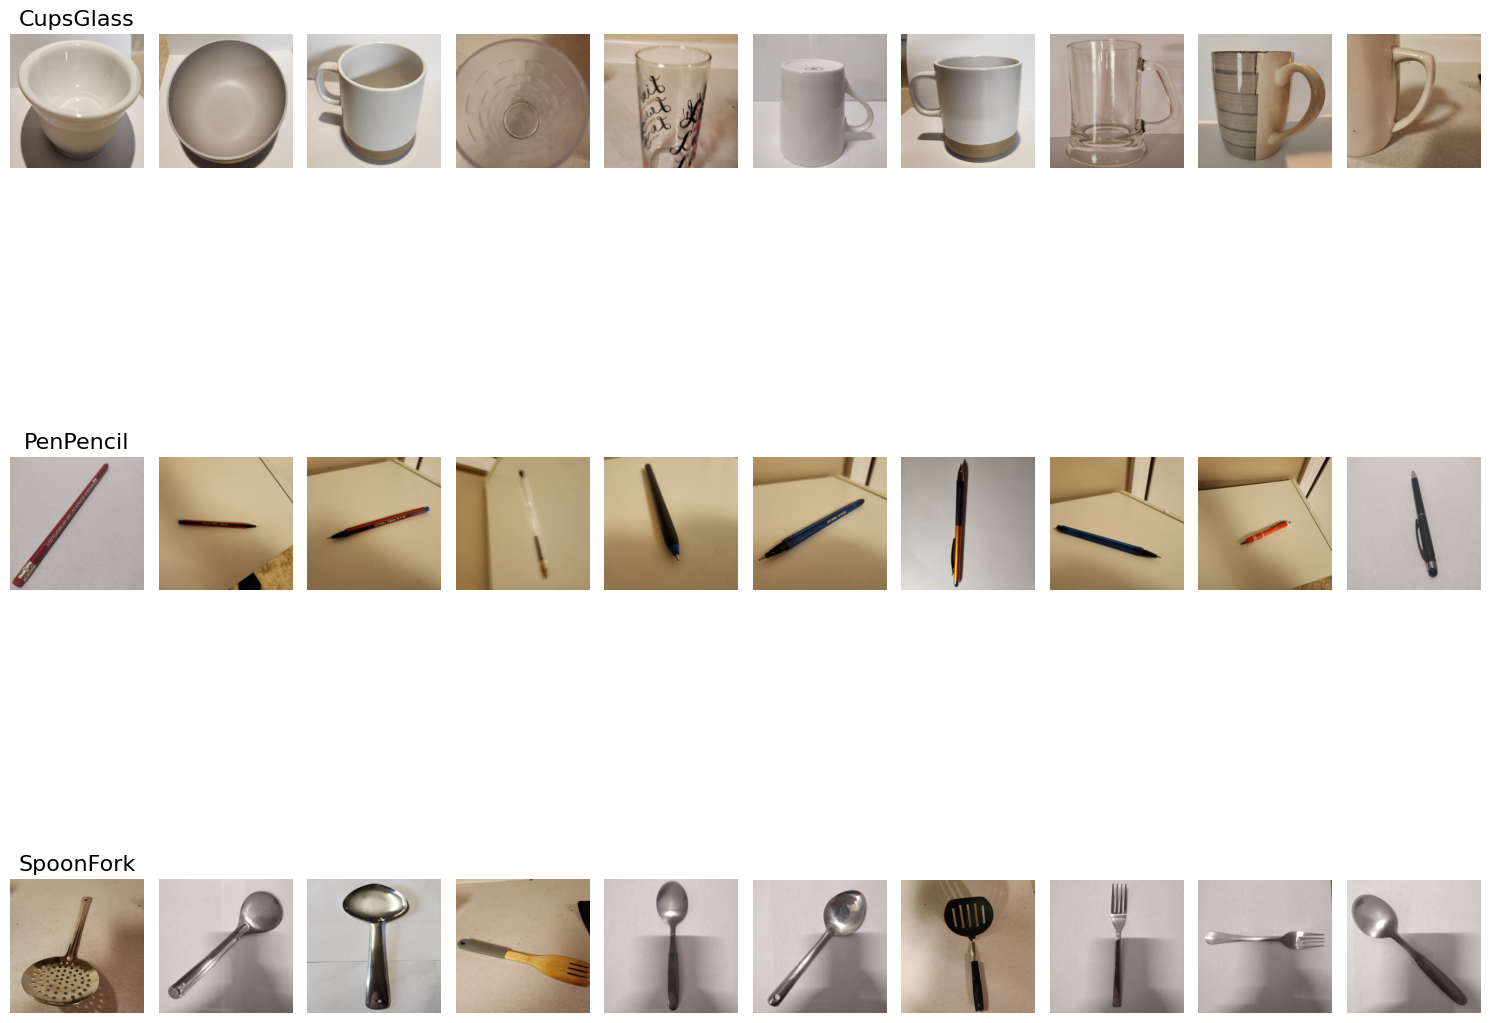

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


dataset_dir = "Dataset"

classes = ["CupsGlass", "PenPencil", "SpoonFork"]

num_examples = 10

img_size = (224, 224)

nrows = len(classes)
ncols = num_examples

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
for row, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    
    image_files = os.listdir(class_dir)
    
    examples = random.sample(image_files, num_examples)

    for col, example in enumerate(examples):
        image_path = os.path.join(class_dir, example)
        image = Image.open(image_path).resize(img_size)
        
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    axes[row, 0].set_title(class_name, fontsize=16)

plt.tight_layout()
plt.show()


#### Split the images into a training set, a validation set, and a test set.

In [15]:
import os
import random
from sklearn.model_selection import train_test_split
from shutil import copyfile

dataset_dir = "Dataset"
train_dir = "Train"
val_dir = "Validation"
test_dir = "Test"

classes = ["CupsGlass", "PenPencil", "SpoonFork"]

img_size = (224, 224)

train_pct = 0.6  # 70% for training
val_pct = 0.2  # 10% for validation
test_pct = 0.2  # 20% for testing

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)

    image_files = os.listdir(class_dir)

    train_files, test_files = train_test_split(image_files, test_size=test_pct, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_pct/(1-test_pct), random_state=42)

    # Copy the training images to the training directory
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    for file_name in train_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(train_class_dir, file_name)
        copyfile(src_path, dst_path)

    # Copy the validation images to the validation directory
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)
    for file_name in val_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(val_class_dir, file_name)
        copyfile(src_path, dst_path)

    # Copy the test images to the test directory
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)
    for file_name in test_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(test_class_dir, file_name)
        copyfile(src_path, dst_path)


#### Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (224, 224)


train_dir = "Train"
val_dir = "Validation"
test_dir = "Test"

train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=20, # Rotate the images randomly
    width_shift_range=0.2, # Shift the images horizontally
    height_shift_range=0.2, # Shift the images vertically
    shear_range=0.2, # Shear the images
    zoom_range=0.2, # Zoom the images
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size, 
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False, 
    seed=42 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size, 
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, 
    seed=42 
)

Found 228 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Found 78 images belonging to 3 classes.


In [5]:
os.listdir()

['q1.ipynb', 'Dataset', 'q1 - Ani Data.ipynb', 'Train', 'Validation', 'Test']

#### d. Fine-tune a pretrained model of your choice on this dataset (the one you created in part c). Report classification accuracy and give a few examples of correct/incorrect classification (show a few images that were correctly/incorrectly classified).

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))
num_classes = 3
for layer in base_model.layers:
    layer.trainable = False

In [33]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.1),
    metrics=['accuracy'],
    run_eagerly=True
)


history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=None,
    validation_data=val_generator,
    validation_steps=None
)


test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)


Epoch 1/10
8/8 [==============================] - 25s 3s/step - loss: 502.7955 - accuracy: 0.4825 - val_loss: 41.4244 - val_accuracy: 0.6410
Epoch 2/10
8/8 [==============================] - 24s 3s/step - loss: 14.4318 - accuracy: 0.5789 - val_loss: 1.2303 - val_accuracy: 0.8205
Epoch 3/10
8/8 [==============================] - 24s 3s/step - loss: 0.7478 - accuracy: 0.7632 - val_loss: 0.6524 - val_accuracy: 0.8077
Epoch 4/10
8/8 [==============================] - 23s 3s/step - loss: 0.6014 - accuracy: 0.6886 - val_loss: 0.5653 - val_accuracy: 0.6795
Epoch 5/10
8/8 [==============================] - 23s 3s/step - loss: 0.5157 - accuracy: 0.6754 - val_loss: 0.4659 - val_accuracy: 0.8846
Epoch 6/10
8/8 [==============================] - 24s 3s/step - loss: 2.6495 - accuracy: 0.7237 - val_loss: 0.3300 - val_accuracy: 0.9231
Epoch 7/10
8/8 [==============================] - 22s 3s/step - loss: 0.7214 - accuracy: 0.8465 - val_loss: 0.2354 - val_accuracy: 0.9744
Epoch 8/10
8/8 [==============

In [34]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [35]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)

3/3 [==============================] - 4s 1s/step - loss: 0.3360 - accuracy: 0.9103
Test accuracy: 0.9102563858032227
3/3 [==============================] - 4s 1s/step


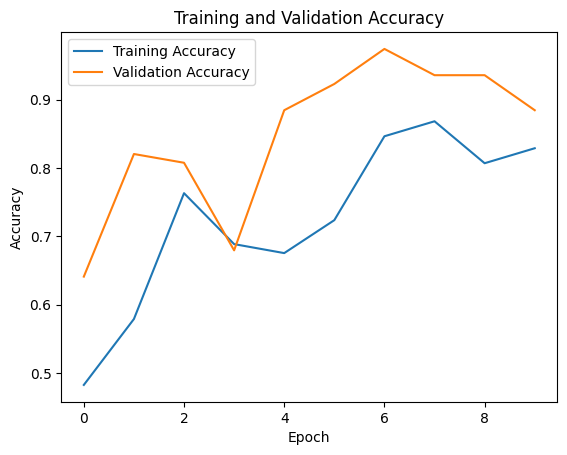

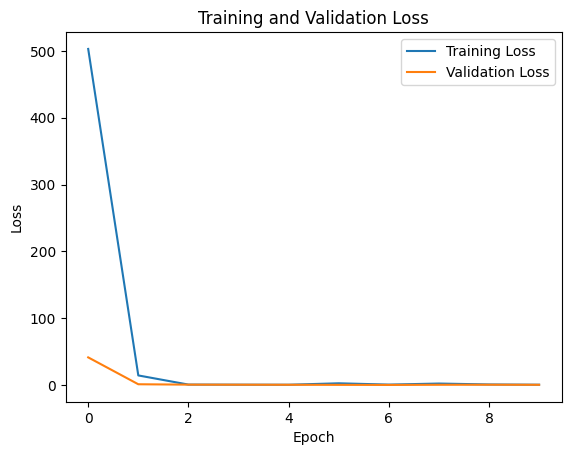

In [36]:
import matplotlib.pyplot as plt

# Get the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curve
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import classification_report

predictions = model.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, y_pred, target_names=class_names))


3/3 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

   CupsGlass       1.00      0.93      0.96        27
   PenPencil       0.79      1.00      0.88        26
   SpoonFork       1.00      0.80      0.89        25

    accuracy                           0.91        78
   macro avg       0.93      0.91      0.91        78
weighted avg       0.93      0.91      0.91        78



3/3 [==============================] - 4s 1s/step
Examples of correctly classified images:


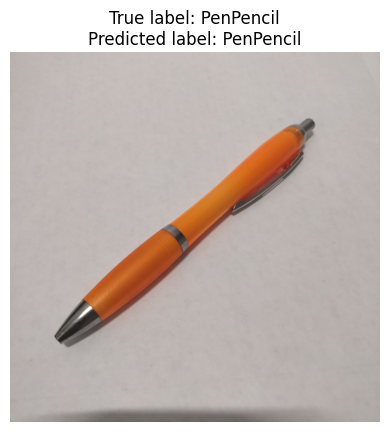

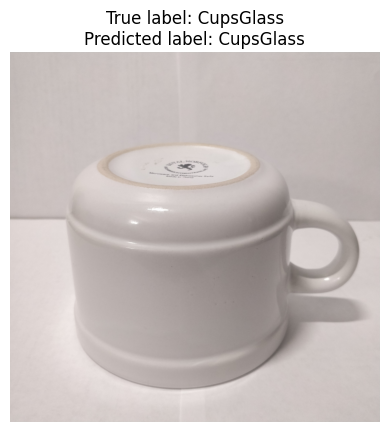

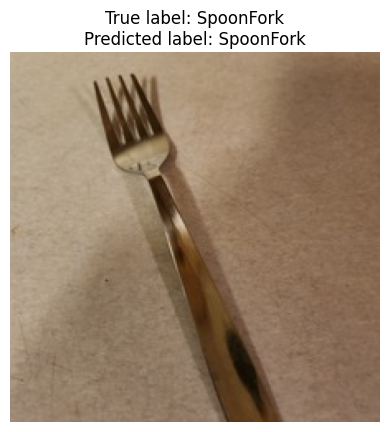

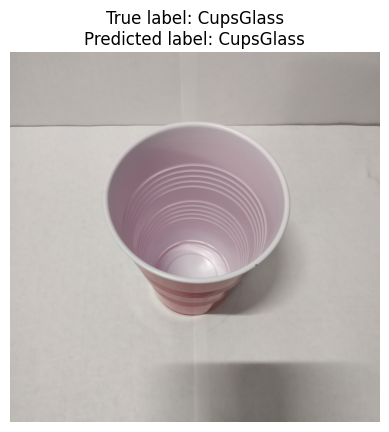

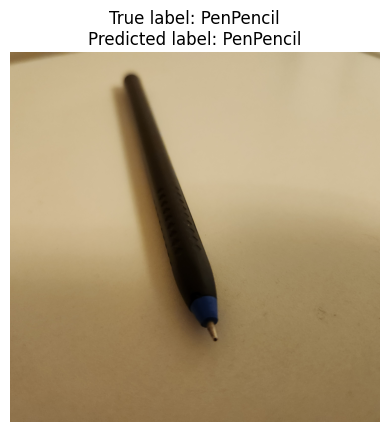

Examples of incorrectly classified images:


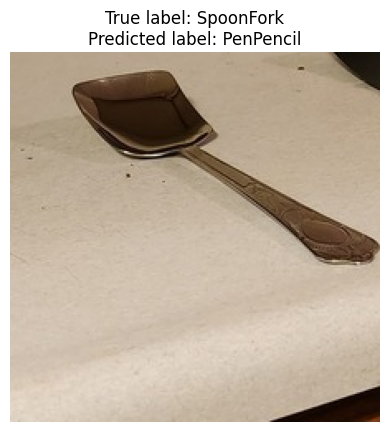

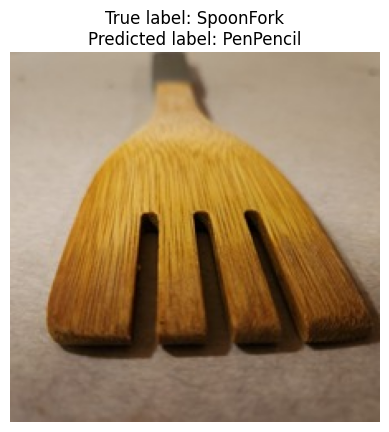

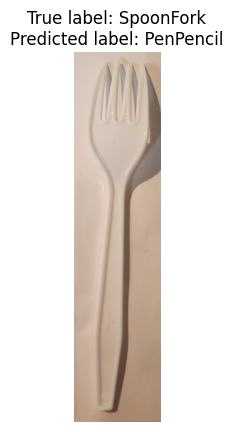

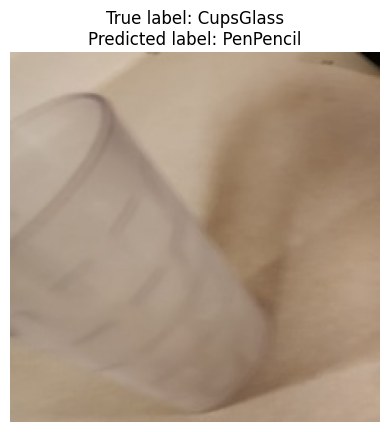

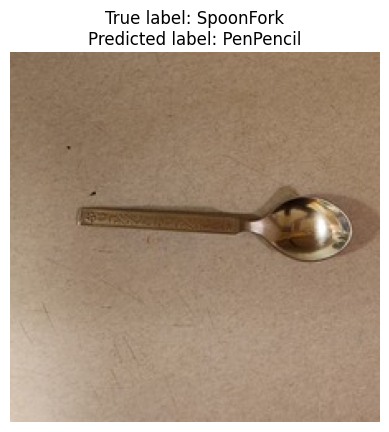

In [39]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
class_labels = list(train_generator.class_indices.keys())

correct_indices = np.where(np.argmax(predictions, axis=-1) == test_generator.classes)[0]
correct_images = np.random.choice(correct_indices, size=5, replace=False)

print("Examples of correctly classified images:")
for idx in correct_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()

# Plot some incorrectly classified images
incorrect_indices = np.where(np.argmax(predictions, axis=-1) != test_generator.classes)[0]
incorrect_images = np.random.choice(incorrect_indices,size=5, replace=False)

print("Examples of incorrectly classified images:")
for idx in incorrect_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()


#### Fine tuning by changing the parameters

In [47]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))

num_classes = 3


for layer in base_model.layers[:-3]:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x) 
x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.0001),
    metrics=['accuracy']
)

class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print('Stop training ')
            self.model.stop_training = True

stop_training_callback = StopTrainingCallback()

# Use early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=None,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stop, stop_training_callback]
)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)


Epoch 1/50
8/8 [==============================] - 22s 2s/step - loss: 10.9871 - accuracy: 0.3333 - val_loss: 10.0823 - val_accuracy: 0.6282
Epoch 2/50
8/8 [==============================] - 19s 2s/step - loss: 9.6395 - accuracy: 0.5439 - val_loss: 8.8057 - val_accuracy: 0.6795
Epoch 3/50
8/8 [==============================] - 19s 2s/step - loss: 8.3307 - accuracy: 0.7018 - val_loss: 7.5090 - val_accuracy: 0.9231
Epoch 4/50
8/8 [==============================] - 18s 2s/step - loss: 7.4259 - accuracy: 0.7939 - val_loss: 6.9285 - val_accuracy: 0.8333
Epoch 5/50
8/8 [==============================] - 19s 2s/step - loss: 6.6764 - accuracy: 0.8289 - val_loss: 6.1243 - val_accuracy: 0.8846
Epoch 6/50
8/8 [==============================] - 20s 2s/step - loss: 5.9837 - accuracy: 0.8377 - val_loss: 5.6238 - val_accuracy: 0.9487
Epoch 7/50
8/8 [==============================] - 20s 3s/step - loss: 5.5026 - accuracy: 0.8816 - val_loss: 5.1022 - val_accuracy: 0.9359
Epoch 8/50
8/8 [================

In [48]:
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [49]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)

3/3 [==============================] - 4s 984ms/step - loss: 2.1252 - accuracy: 0.9744
Test accuracy: 0.9743589758872986
3/3 [==============================] - 4s 1s/step


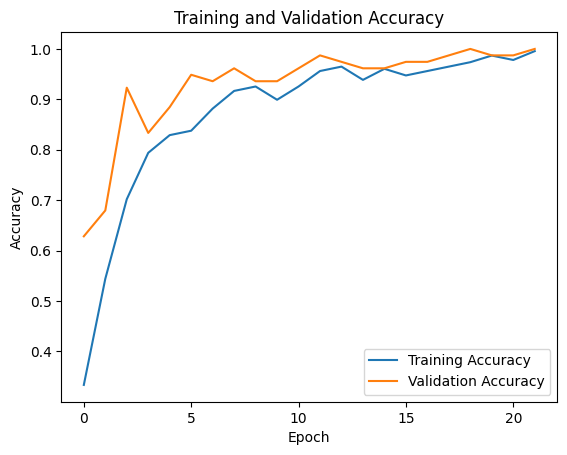

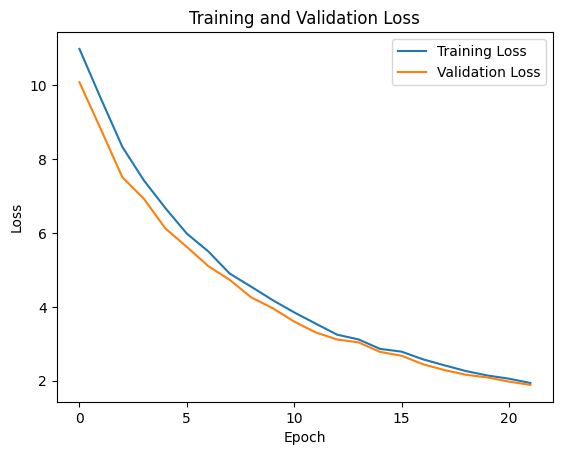

In [50]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [51]:
from sklearn.metrics import classification_report

predictions = model.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))


3/3 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

   CupsGlass       0.93      1.00      0.96        27
   PenPencil       1.00      0.96      0.98        26
   SpoonFork       1.00      0.96      0.98        25

    accuracy                           0.97        78
   macro avg       0.98      0.97      0.97        78
weighted avg       0.98      0.97      0.97        78



3/3 [==============================] - 4s 1s/step
Examples of correctly classified images:


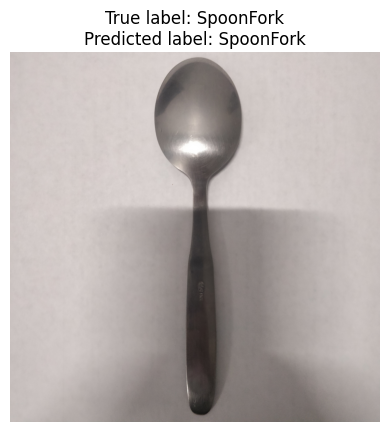

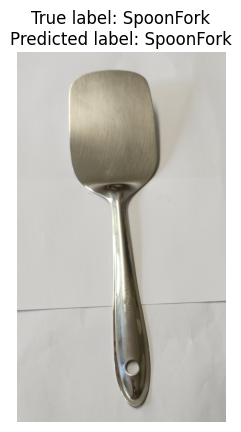

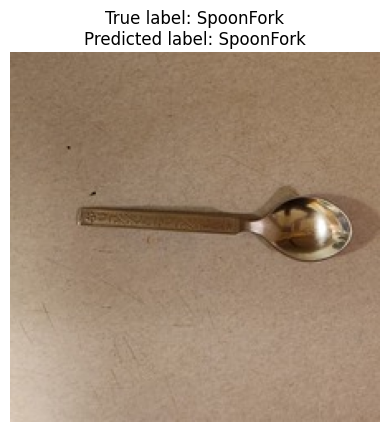

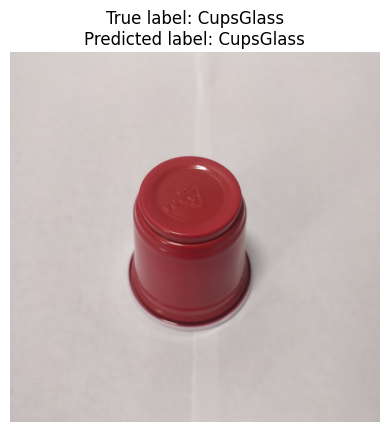

Examples of incorrectly classified images:


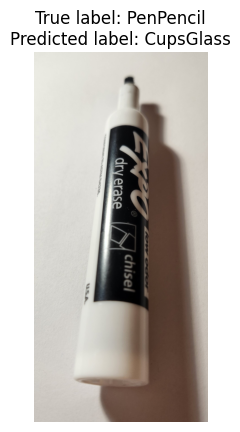

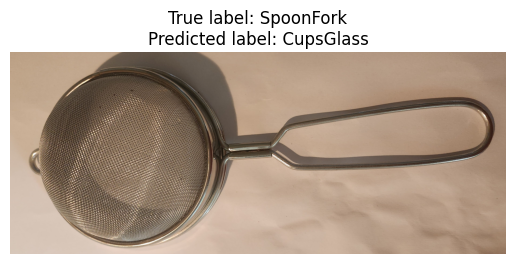

In [54]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
class_labels = list(train_generator.class_indices.keys())

correct_indices = np.where(np.argmax(predictions, axis=-1) == test_generator.classes)[0]
correct_images = np.random.choice(correct_indices, size=4, replace=False)

print("Examples of correctly classified images:")
for idx in correct_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()

# Plot some incorrectly classified images
incorrect_indices = np.where(np.argmax(predictions, axis=-1) != test_generator.classes)[0]
incorrect_images = np.random.choice(incorrect_indices,size=2, replace=False)

print("Examples of incorrectly classified images:")
for idx in incorrect_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()


#### After achieving a test accuracy of around 91% using default parameters, we applied some fine-tuning such as l2 regularization, dropout layer, unfreezing 3 layers and could see that the testing accuracy now increased to 97%